<a href="https://colab.research.google.com/github/bmayra2009/Diabetes_classification/blob/main/Diabetes_130_US_hospitals_readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical Excersice
### Mayra Bustamante
### Data Scientist

# 1. Business Problem

Assesment:

In "Diabetes 130-US hospitals for years 1999-2008 Data Set" you have 3 different outputs:

* No readmission;

* A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);

* A readmission in more than 30 days (this one is not so good as well the last one, however, the reason could be the state of the patient.

Your task is either to classify a patient-hospital outcome or to cluster them aiming at finding patterns that give a distinct insight.

Dataset: 

The data includes 101,766 rows and 50 columns (5,088,300 data points). Of all 50 columns, 37 are nominal, 13 are numeric.
The output variable is the column labeled “readmitted” which is encoded a 3-class classifier including “<30 days”, “>30
days”, “Not readmitted”. The full initial set of data also comprises 2 ID type variables, “Encounter ID” and “Patient Nbr”

Solution: 

We follow some of the pre-processing and feature engineering steps from https://thesai.org/Downloads/Volume10No2/Paper_36-Predicting_30_Day_Hospital_Readmission_for_Diabetes_Patients.pdf 

## 2. Data Pre-processing

We have two datasets: diabetic_data and IDs_mapping. First one is the main database and the second one has some dictionaries from ids and descriptions of admission_source, admission_type and discharge_disposition_id. We are going to work with the first dataset.

In [59]:
#Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from collections import Counter
from sklearn.model_selection import GridSearchCV; 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import roc_curve, auc 
from imblearn.over_sampling import SMOTE
import scipy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [2]:
#Read diabetic_data from csv
diabetic_data_inicial = pd.read_csv("diabetic_data.csv")

In [3]:
#Columns names
print(diabetic_data_inicial.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


"Several patients from the medical records had multiple admission and should not be treated as an independent encounter as it would bias other observations. In order to ensure a unique identifier for each patient, previous researchers suggested keeping only the first encounter when a patient had multiple record."

In [4]:
#We keep only the first encounter per patient to address bias in data
diabetic_data_inicial.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)

discharge_disposition_id refers to the person's location or status after admission in the healthcare center. For that reason we remove code associated wih Expired.

In [5]:
#Remove disposition code associated with ‘Expired’ since not relevant to readmission
diabetic_data_inicial = diabetic_data_inicial[~diabetic_data_inicial.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [6]:
#Print database info to know about null values and datatypes
print(diabetic_data_inicial.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              69973 non-null  int64 
 1   patient_nbr               69973 non-null  int64 
 2   race                      69973 non-null  object
 3   gender                    69973 non-null  object
 4   age                       69973 non-null  object
 5   weight                    69973 non-null  object
 6   admission_type_id         69973 non-null  int64 
 7   discharge_disposition_id  69973 non-null  int64 
 8   admission_source_id       69973 non-null  int64 
 9   time_in_hospital          69973 non-null  int64 
 10  payer_code                69973 non-null  object
 11  medical_specialty         69973 non-null  object
 12  num_lab_procedures        69973 non-null  int64 
 13  num_procedures            69973 non-null  int64 
 14  num_medications      

We have 50 variables, in the initial revision none of them has null values

Variables description. Source: Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records (https://www.hindawi.com/journals/bmri/2014/781670/) 

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [7]:
#First rows of the database
diabetic_data_inicial.head(15)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


We can see that even though there are no null records, data with text "?" is found and it would represent null values. Therefore we replace these values by NA

In [8]:
#Replacing ? with NA
diabetic_data=diabetic_data_inicial.replace('?', np.NaN)

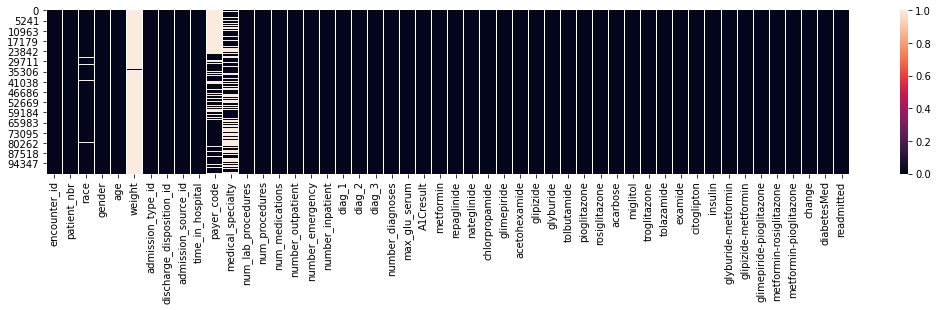

In [9]:
#Graphic that shows null behavior
fig, ax = plt.subplots(figsize=(18, 3))
ax = sns.heatmap(diabetic_data.isna())

The graph above shows the behavior of null values through all variables, we can see there are some of them with many null values. Now we identify them

In [10]:
#Percentage of null values in each column
columns=diabetic_data.isnull().mean().round(4).mul(100).sort_values(ascending=False)

In [11]:
print(columns)

weight                      96.02
medical_specialty           48.07
payer_code                  43.47
race                         2.74
diag_3                       1.75
diag_2                       0.42
diag_1                       0.01
num_procedures               0.00
max_glu_serum                0.00
number_diagnoses             0.00
number_inpatient             0.00
number_emergency             0.00
number_outpatient            0.00
num_medications              0.00
readmitted                   0.00
num_lab_procedures           0.00
diabetesMed                  0.00
time_in_hospital             0.00
admission_source_id          0.00
discharge_disposition_id     0.00
admission_type_id            0.00
age                          0.00
gender                       0.00
patient_nbr                  0.00
A1Cresult                    0.00
metformin                    0.00
repaglinide                  0.00
nateglinide                  0.00
change                       0.00
metformin-piog

Only 7/50 columns have null values, just one of them has a percentage bigger than 50% then we will drop it and we will impute and transform the other 6.

In [12]:
#We are going to select variables with more than 35% of null values to drop them
diabetic_data=diabetic_data.loc[:, diabetic_data.isnull().mean() < .5]

In [13]:
#Database is divided in 4 databases to analyze the columns
cols = diabetic_data.columns.values
df_1 = diabetic_data[cols[:20]]
df_2 = diabetic_data[cols[20:40]]
df_3 = diabetic_data[cols[40:-1]]

In [14]:
#Description of database part 1
(df_1).describe(include="all")

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3
count,6.997300e+04,6.997300e+04,68055,69973,69973,69973.000000,69973.000000,69973.000000,69973.000000,39558,36334,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69963,69680,68749
unique,NaN,NaN,5,3,10,NaN,NaN,NaN,NaN,17,70,NaN,NaN,NaN,NaN,NaN,NaN,694,723,756
top,NaN,NaN,Caucasian,Female,[70-80),NaN,NaN,NaN,NaN,MC,InternalMedicine,NaN,NaN,NaN,NaN,NaN,NaN,414,250,250
freq,NaN,NaN,52292,37229,17750,NaN,NaN,NaN,NaN,19782,10641,NaN,NaN,NaN,NaN,NaN,NaN,5209,4996,8980
mean,1.566286e+08,5.493770e+07,NaN,NaN,NaN,2.107113,3.412588,5.636217,4.273220,NaN,NaN,42.876038,1.425536,15.665257,0.279536,0.103912,0.176254,NaN,NaN,NaN
std,1.003493e+08,3.948019e+07,NaN,NaN,NaN,1.509513,5.180513,4.165653,2.933924,NaN,NaN,19.894530,1.757131,8.287246,1.064035,0.511870,0.601657,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,8.129994e+07,2.334182e+07,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,1.438572e+08,4.797652e+07,NaN,NaN,NaN,1.000000,1.000000,7.000000,3.000000,NaN,NaN,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
75%,2.153448e+08,8.749500e+07,NaN,NaN,NaN,3.000000,3.000000,7.000000,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [15]:
#Description of database part 2
(df_2).describe(include="all")

,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton
count,69973.000000,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973
unique,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,3,4,2,2,1,1
top,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
freq,NaN,66625,57128,55070,69056,69482,69902,66276,69972,60966,62198,69956,64710,65312,69773,69953,69970,69943,69973,69973
mean,7.223743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.001354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Description of database part 3
(df_3).describe(include="all")

,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,69973,69973,69973,69973,69973,69973,69973,69973
unique,4,4,2,1,2,2,2,2
top,No,No,No,No,No,No,No,Yes
freq,34258,69477,69966,69973,69971,69972,38482,53293


With the description of the database we can see there are two variables with 100% of registers in same category, these are: examide and citoglipton,glimepiride-pioglitazone,. 
There are also variables with moree than 98% of values in one category: repaglinide, nateglinide, chlorpropamide, acetohexamide, tolbutamide, acarbose, miglitol, troglitazone, tolazamide, glyburide-metformin.

In [17]:
#We drop null variables and ID variables
diabetic_data=diabetic_data.drop(['examide','citoglipton','repaglinide', 
                                  'nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 
                                  'troglitazone', 'tolazamide', 'glyburide-metformin','encounter_id','patient_nbr'],axis=1)

In [18]:
#Print database info to know about null values and datatypes
print(diabetic_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 0 to 101765
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      68055 non-null  object
 1   gender                    69973 non-null  object
 2   age                       69973 non-null  object
 3   admission_type_id         69973 non-null  int64 
 4   discharge_disposition_id  69973 non-null  int64 
 5   admission_source_id       69973 non-null  int64 
 6   time_in_hospital          69973 non-null  int64 
 7   payer_code                39558 non-null  object
 8   medical_specialty         36334 non-null  object
 9   num_lab_procedures        69973 non-null  int64 
 10  num_procedures            69973 non-null  int64 
 11  num_medications           69973 non-null  int64 
 12  number_outpatient         69973 non-null  int64 
 13  number_emergency          69973 non-null  int64 
 14  number_inpatient     

**Conclusions:**

Finally we have 35 columns, six of them with null values we are going to impute.


## 3. Data Preprocessing

We can reduce the categories in the variable diag_1 using expert knowledge.

![image.png](attachment:image.png)

**Missingnes**

We have to impute variables diag_1, diag_2 and diag_3,race, these are categorical variables so we are going to fill null values with the most common categories

In [19]:
diabetic_data=diabetic_data.fillna("?")
#Get most common categories
diag_1 = Counter(list(diabetic_data["diag_1"])).most_common(1)[0][0]
diag_2 = Counter(list(diabetic_data["diag_2"])).most_common(1)[0][0]
diag_3 = Counter(list(diabetic_data["diag_3"])).most_common(1)[0][0]
race = Counter(list(diabetic_data["race"])).most_common(1)[0][0]
#Fill NA with most common categories per variable
diabetic_data["diag_1"] = diabetic_data["diag_1"].apply(lambda x : diag_1 if x == "?" else x)
diabetic_data["diag_2"] = diabetic_data["diag_2"].apply(lambda x : diag_2 if x == "?" else x)
diabetic_data["diag_3"] = diabetic_data["diag_3"].apply(lambda x : diag_3 if x == "?" else x)
diabetic_data["race"] = diabetic_data["race"].apply(lambda x : race if x == "?" else x)

In [20]:
#Cluster medical specialty and fill NA (?) with word "missing"
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Proctology','Dermatology','SportsMedicine','Speech','Perinatology',
                'Resident','Pediatrics-Hematology-Oncology','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Anesthesiology','Pathology',
                'Endocrinology-Metabolism','PhysicianNotFound','OutreachServices',
                'Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', 
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', 
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']


missing = ['?']

diabetic_data['medical_specialty'] = diabetic_data['medical_specialty'].apply(lambda x : 'high_frequency' if x in high_frequency  
                                        else ('low_frequency' if x in low_frequency
                                        else ('pediatrics' if x in pediatrics
                                        else ('psychic' if x in psychic
                                        else ('neurology' if x in neurology
                                        else ('surgery' if x in surgery
                                        else ('missing' if x == "?"
                                        else 'ungrouped')))))))

In [21]:
#Replacing ? with NA
diabetic_data=diabetic_data.replace('?', np.NaN)
diabetic_data.payer_code=diabetic_data.ffill().bfill()

**Data reduction**

In [22]:
#Cluster the disposition_id
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].apply(lambda x : 1 if int(float(x)) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(float(x)) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(float(x)) in [12, 15, 16, 17]
                                                                           else ( 18 if int(float(x)) in [25, 26] 
                                                                           else int(x) ))))

In [23]:
#Cluster diag_1
diabetic_data['diag_1'] = diabetic_data['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [24]:
#Cluster diag_2
diabetic_data['diag_2'] = diabetic_data['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [25]:
#Cluster diag_3
diabetic_data['diag_3'] = diabetic_data['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [26]:
#Cluster admission_type_id
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].apply(lambda x : 1 if int(float(x)) in [2, 7]
                                                            else ( 5 if int(float(x)) in [6, 8]
                                                            else int(x) ))

#Cluster_admission_source_id
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].apply(lambda x : 1 if int(float(x)) in [2, 3]
                                                            else ( 4 if int(float(x)) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(float(x)) in [15, 17, 20, 21]
                                                            else ( 11 if int(float(x)) in [13, 14]
                                                            else int(x) ))))
#Cluster A1CResult
diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].apply(lambda x : "Abnormal" if x in ['>7','>8']                                                       
                                                         else ( "Normal" if x == 'Norm'
                                                         else  "Not tested"))

**Transforming variables**

In [27]:
#Transform age from categorical to numeric with interval mean
replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

diabetic_data['age'] = diabetic_data['age'].apply(lambda x : replaceDict[x])

In [28]:
#Transform "change" variable
diabetic_data['change'] = diabetic_data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else 0)

In [29]:
#List of drugs we keep in the dataset
drugList=["metformin", "glimepiride", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", 
          "insulin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]

**New variables**

In [30]:
#Creating variable "number of changes" to identify how many times a medicament dose has changed.
#Creating variable "num meds up" to identify how many times a medicament dose went up
#Creating variable "num meds used" to identify how many medicaments were used on a pacient
number_of_changes = []
num_meds_up = []
num_meds_used = []
for i in range(len(diabetic_data)) :
    changeCount = 0
    medsUp = 0
    medsUsed = 0
    for col in drugList : 
        if diabetic_data.iloc[i][col] in ['Down', 'Up'] :
            changeCount += 1
        if diabetic_data[col].iloc[i] == 'Up':
            medsUp += 1
        if diabetic_data[col].iloc[i] == 'No':
                medsUsed += 1
    number_of_changes.append(changeCount)
    num_meds_up.append(medsUp)
    num_meds_used.append(11-medsUsed)

diabetic_data['number_of_changes'] = number_of_changes
diabetic_data['num_meds_up'] = num_meds_up
diabetic_data['num_meds_used'] = num_meds_used

In [31]:
#Transform drugs variables
for col in drugList:
  diabetic_data[col] = diabetic_data[col].apply(lambda x : 0 if x == 'No' 
                                              else  1)

In [32]:
#Creating variable "severity of disease"
diabetic_data['severity_of_disease'] = (diabetic_data['time_in_hospital'] + diabetic_data['num_procedures'] + diabetic_data['num_medications'] + diabetic_data['num_lab_procedures'] + diabetic_data['number_diagnoses'])

In [33]:
#Creating variable "service utilization"
diabetic_data['Service_utilization'] = (diabetic_data['number_emergency'] + diabetic_data['number_inpatient'] + diabetic_data['number_outpatient'])

**Target variable**

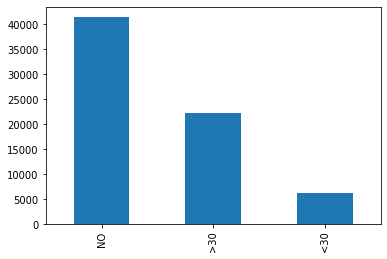

In [34]:
#Target variable graph
diabetic_data['readmitted'].value_counts().plot(kind='bar')

We transform the "readmitted" variable and readmissions occurring after 30 days will be considered as nonreadmission.

In [35]:
#Transforming readmitted variable
def label(x):
    if x=='NO' or x=='>30':
        return 0
    elif x=='<30':
        return 1
diabetic_data['readmitted'] = diabetic_data['readmitted'].apply(label)

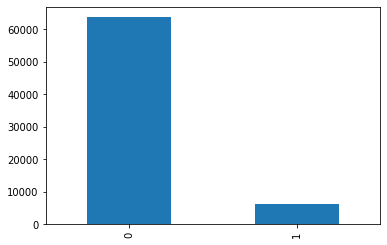

In [36]:
#New target variable graph
diabetic_data['readmitted'].value_counts().plot(kind='bar')

We can see we have unbalanced data

**Info**

In [37]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 0 to 101765
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      69973 non-null  object
 1   gender                    69973 non-null  object
 2   age                       69973 non-null  int64 
 3   admission_type_id         69973 non-null  int64 
 4   discharge_disposition_id  69973 non-null  int64 
 5   admission_source_id       69973 non-null  int64 
 6   time_in_hospital          69973 non-null  int64 
 7   payer_code                69973 non-null  object
 8   medical_specialty         69973 non-null  object
 9   num_lab_procedures        69973 non-null  int64 
 10  num_procedures            69973 non-null  int64 
 11  num_medications           69973 non-null  int64 
 12  number_outpatient         69973 non-null  int64 
 13  number_emergency          69973 non-null  int64 
 14  number_inpatient     

## 4. Exploratory Data Analysis

In [38]:
#Colums split between categorical and numeric based on the description showed before
categorical= ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'diag_1','diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult','payer_code',
       'metformin','glimepiride', 'glipizide', 'glyburide','medical_specialty','readmitted',
       'pioglitazone', 'rosiglitazone', 'insulin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed']
numeric=['time_in_hospital', 'age','num_lab_procedures', 'num_procedures', 'num_medications','number_outpatient', 
           'number_emergency', 'number_inpatient', 'number_diagnoses','number_of_changes','num_meds_up','num_meds_used',
         'severity_of_disease','Service_utilization']

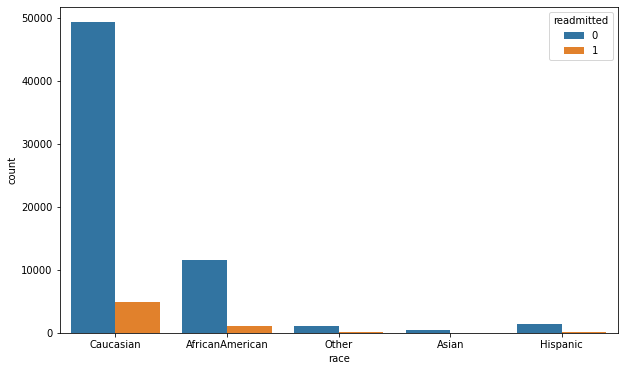

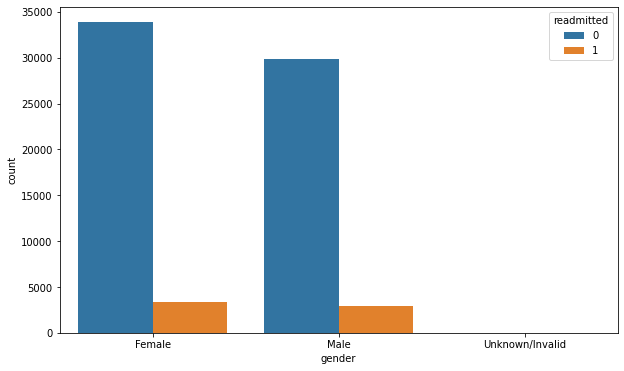

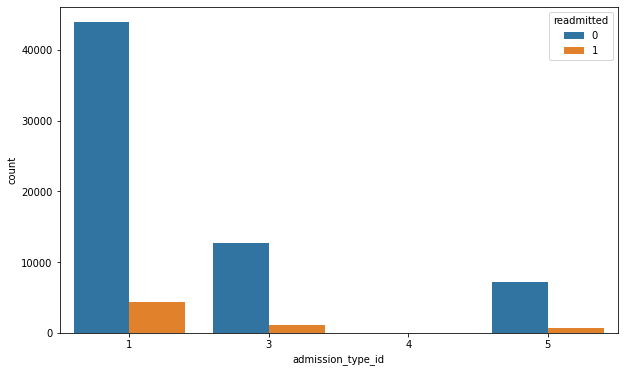

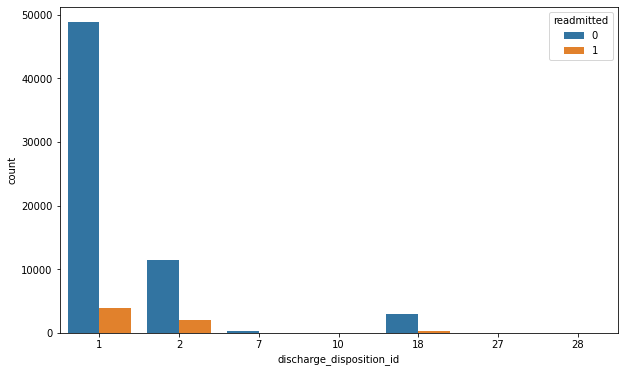

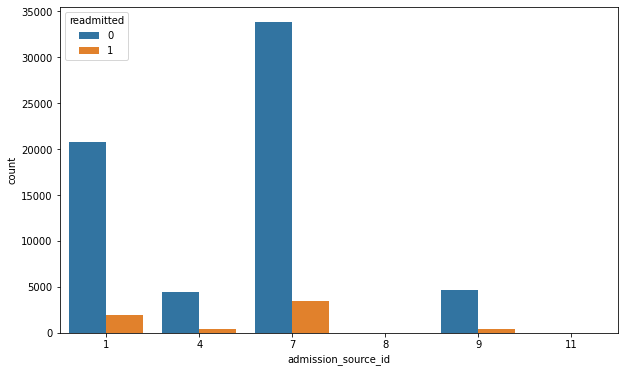

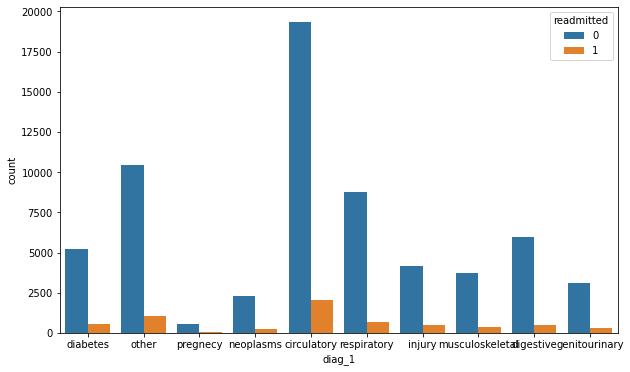

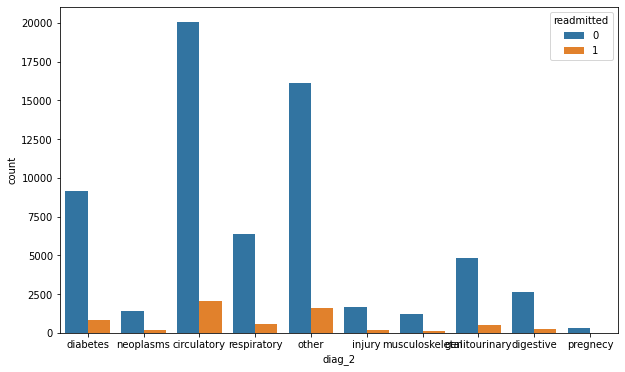

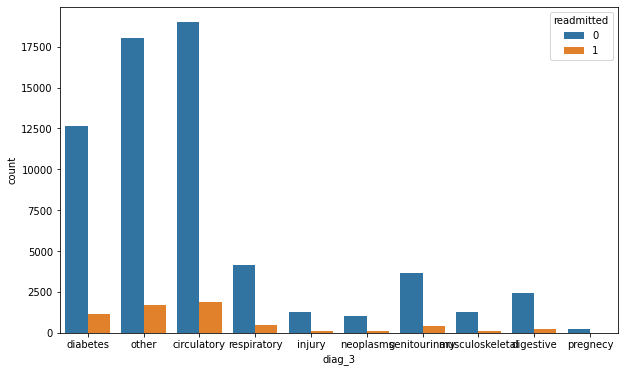

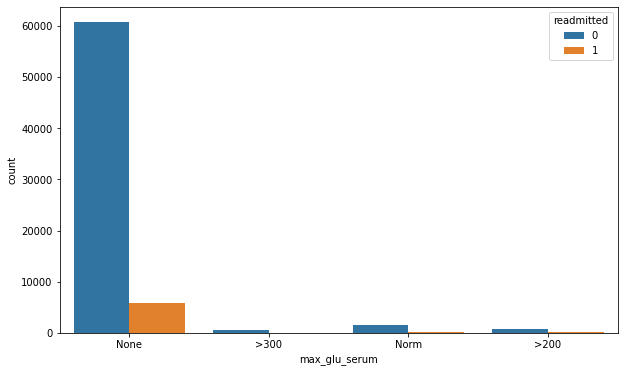

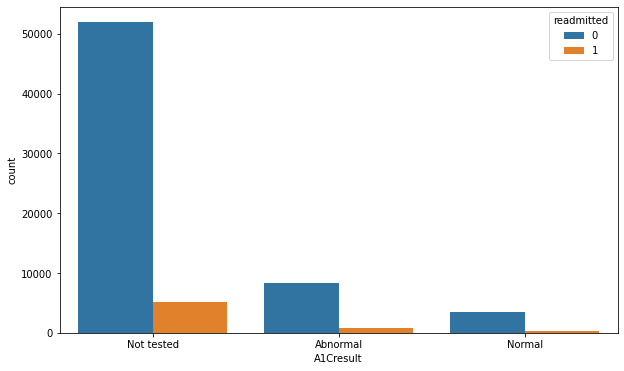

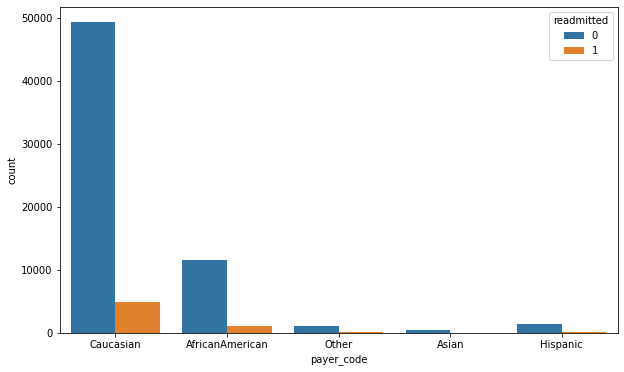

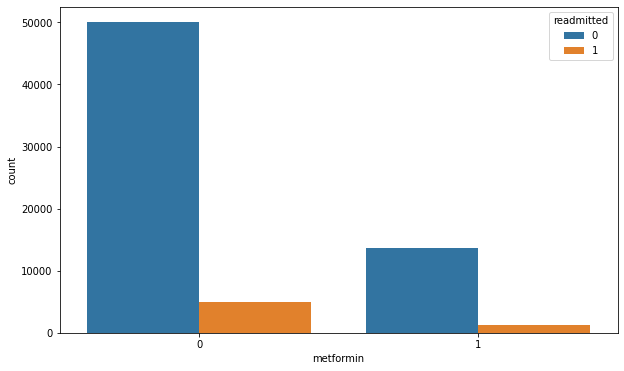

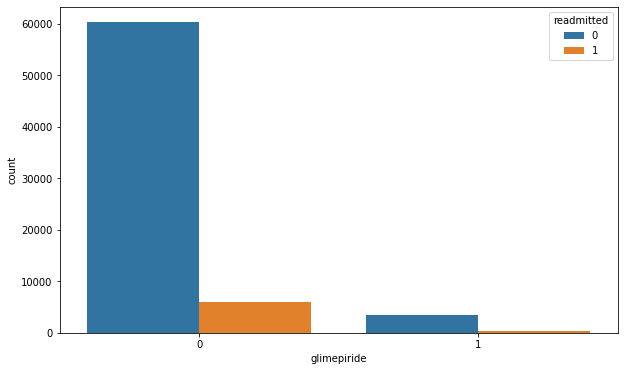

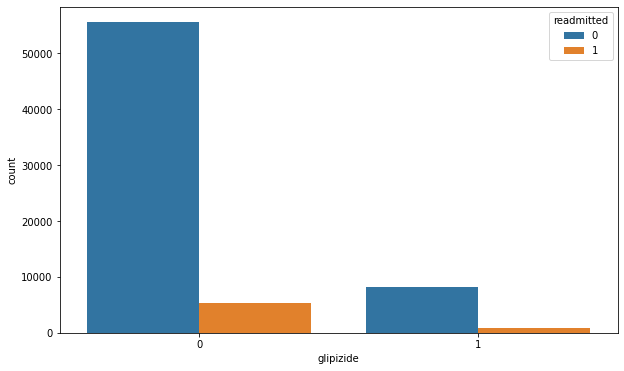

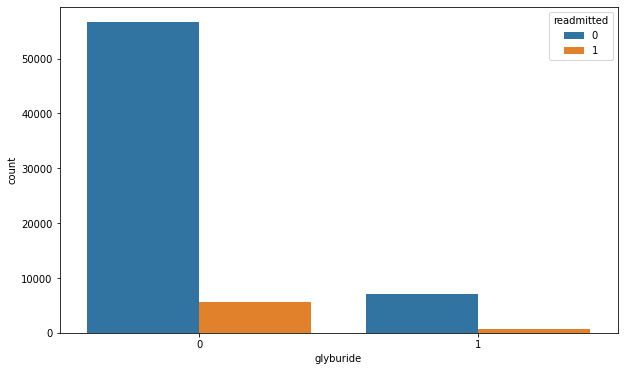

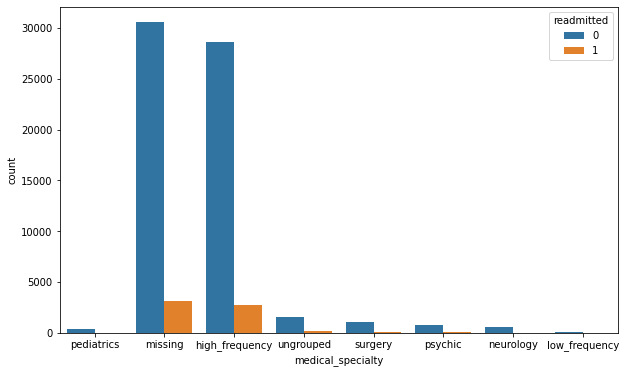

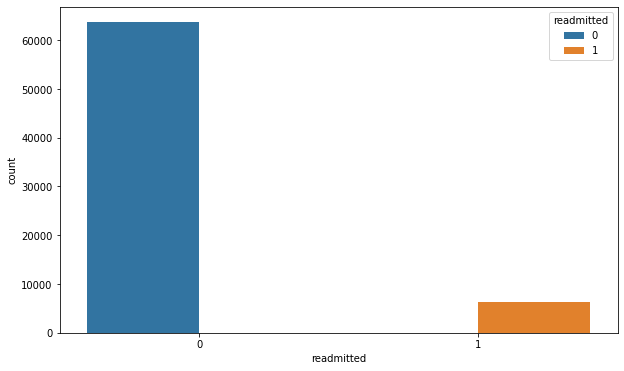

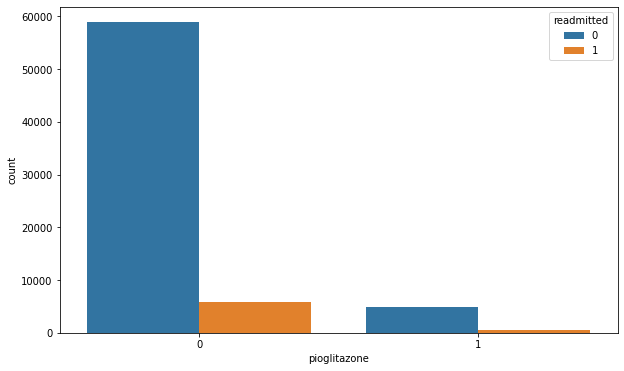

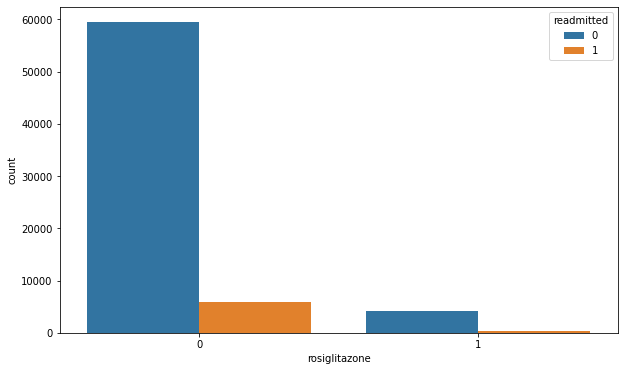

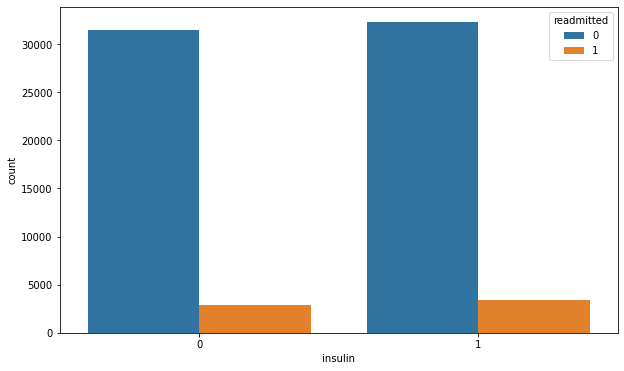

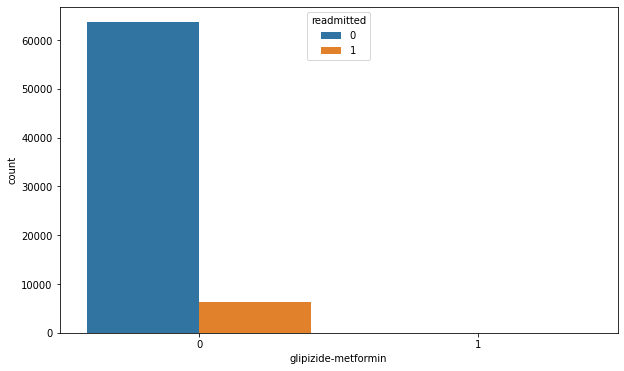

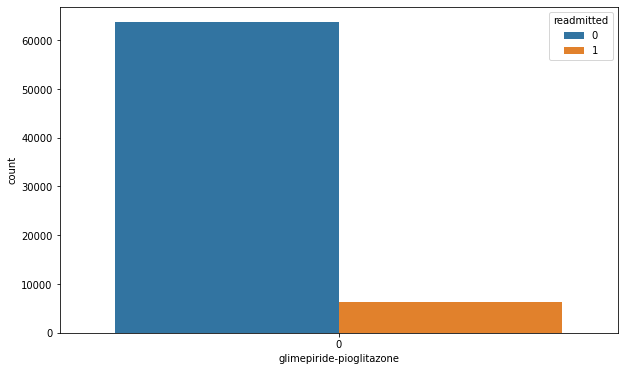

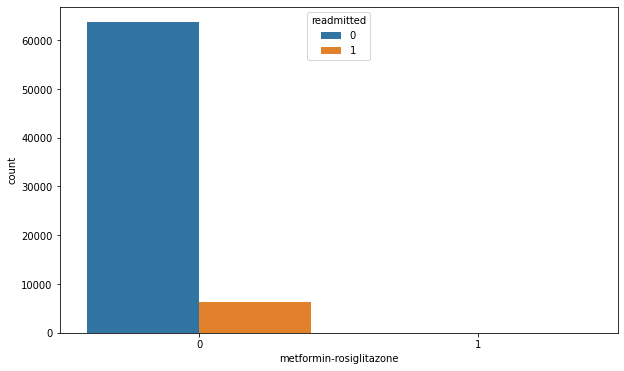

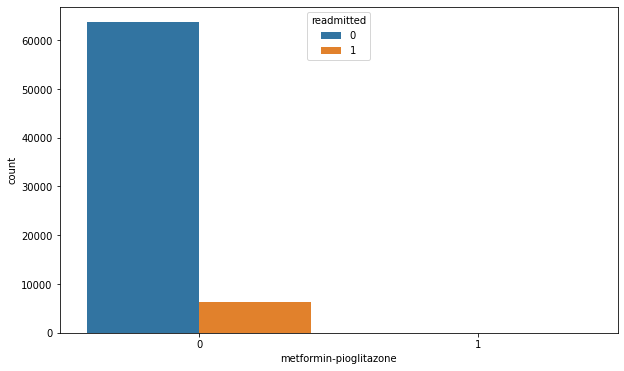

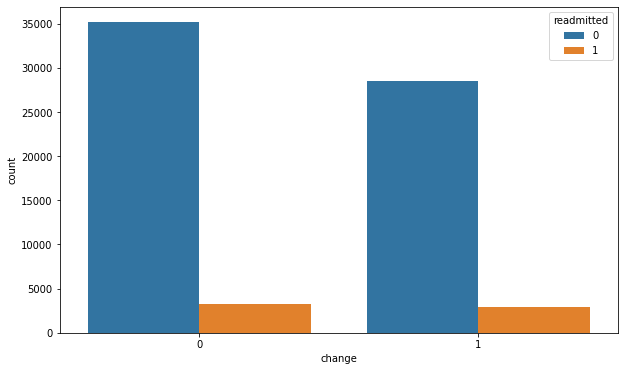

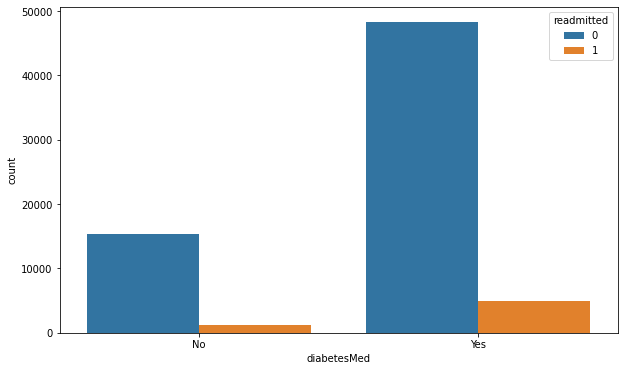

In [39]:
#Univariate analysis categoric variables
for i, feature in enumerate(categorical):
    col_values = diabetic_data[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) <= 10: 
        fig = plt.figure(figsize=(10,6))
        sns.countplot(x=feature, hue="readmitted", data=diabetic_data)
        plt.show()
    else:
        print("Variable "+ feature + " has too many categories")

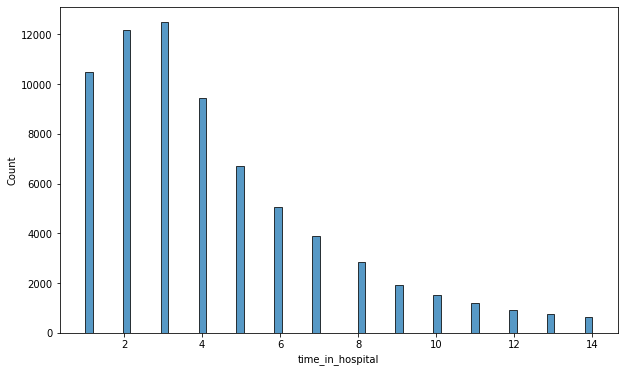

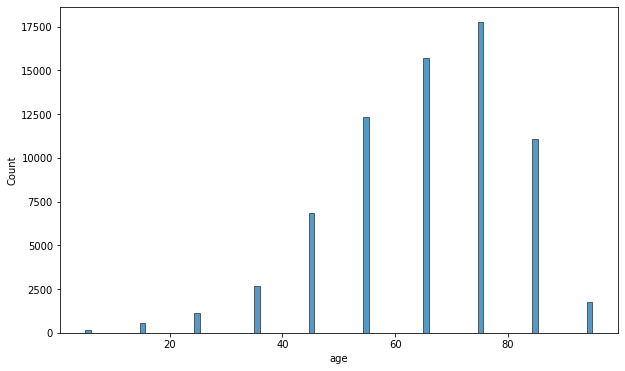

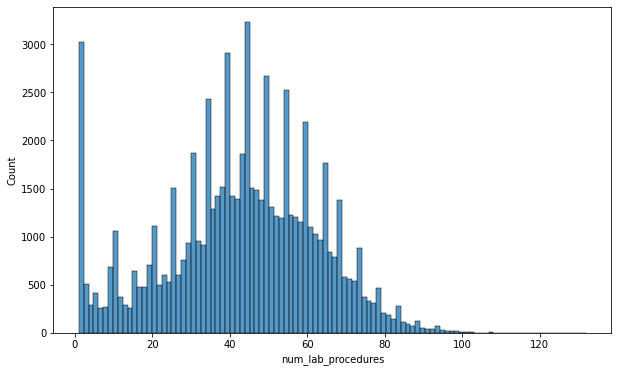

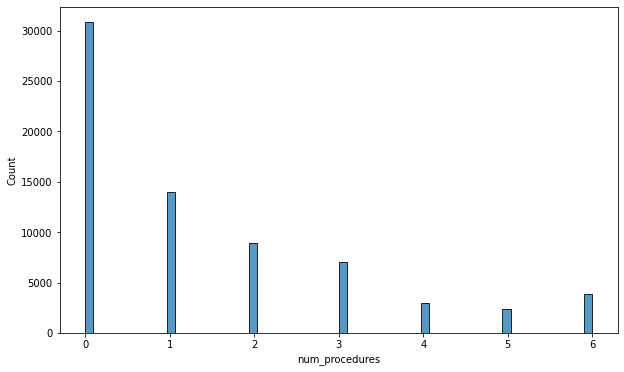

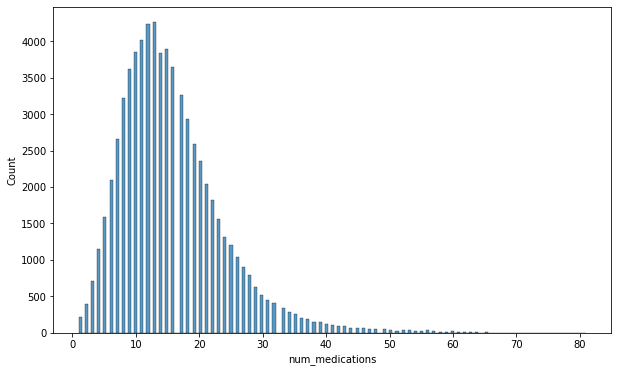

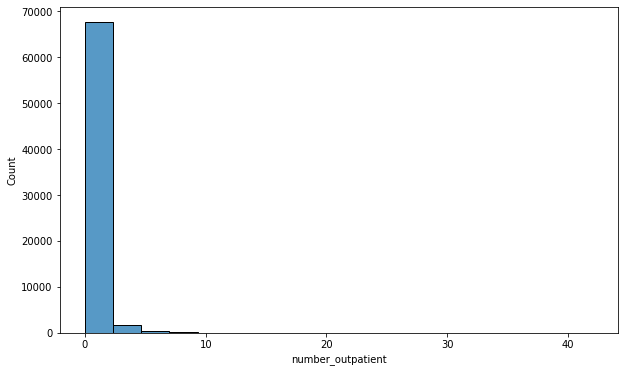

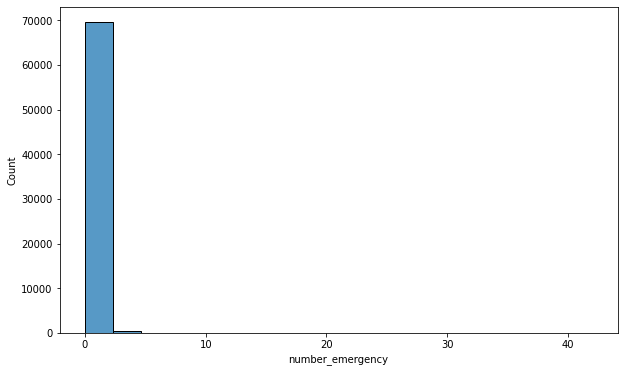

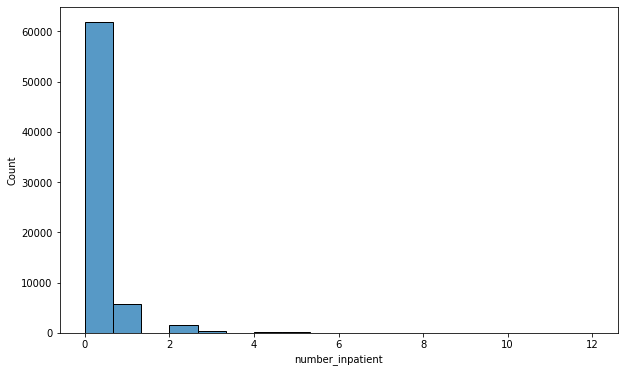

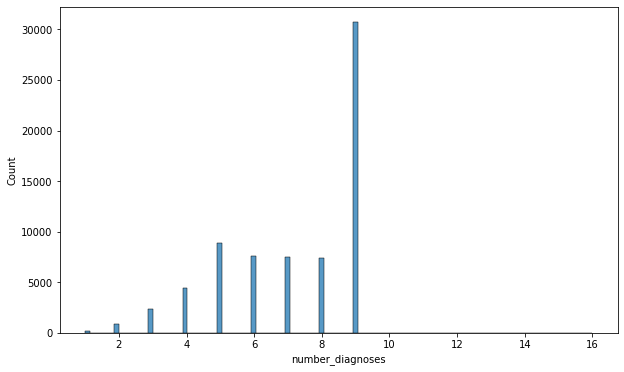

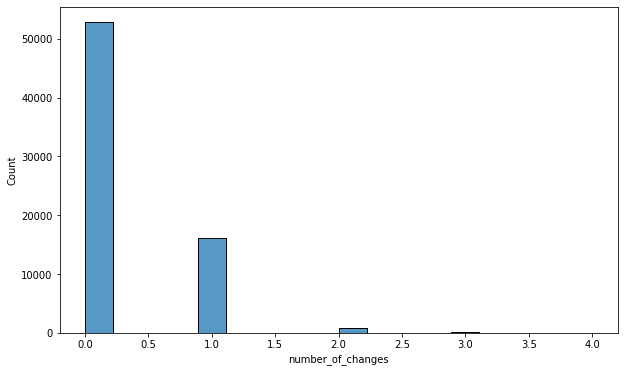

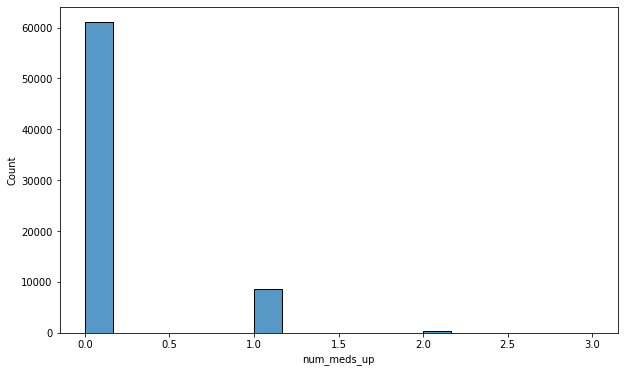

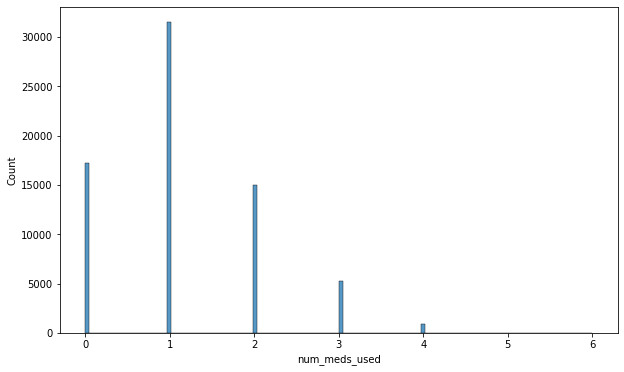

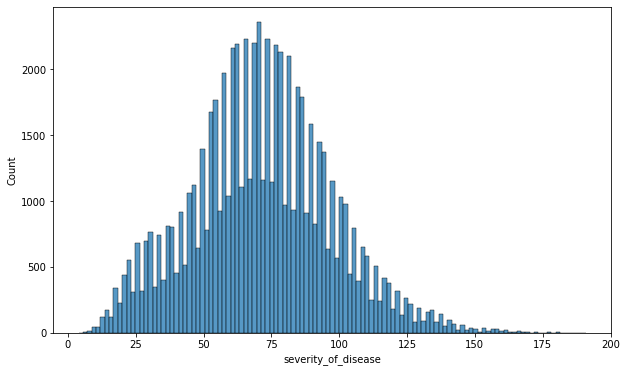

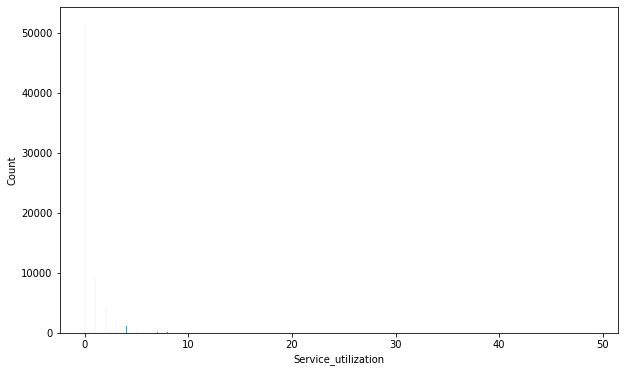

In [40]:
#Univariate analysis categoric variables
for i, feature in enumerate(numeric):
    col_values = diabetic_data[feature]
    fig = plt.figure(figsize=(10,6))
    sns.histplot(x=diabetic_data[feature])
    plt.show()

Most of the numeric features are highly skewed with high kurtosis

In [41]:
#List of positive and negative skewed features
positive_skewed_features=['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency',
                          'number_inpatient','number_diagnoses','number_of_changes','num_meds_up','severity_of_disease','Service_utilization']
negative_skewed_features=['age']

In [42]:
#Transforming numeric variables
for col in positive_skewed_features:
  diabetic_data[col]=np.log(diabetic_data[col]+1)
for col in negative_skewed_features:
  diabetic_data[col]=diabetic_data[col]**(1/3)

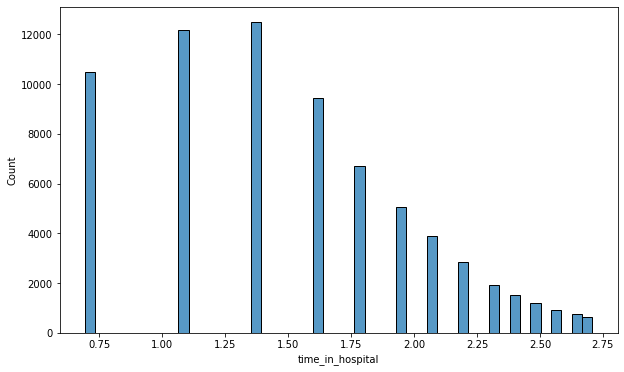

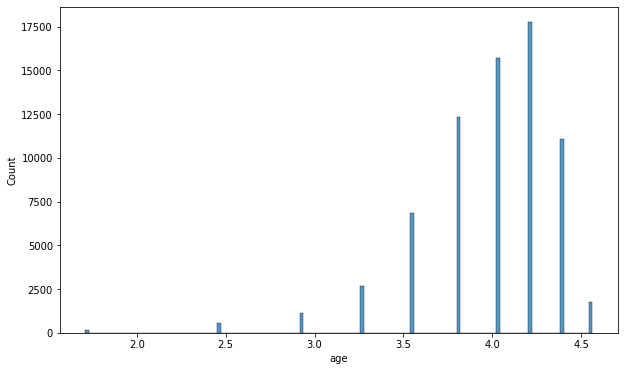

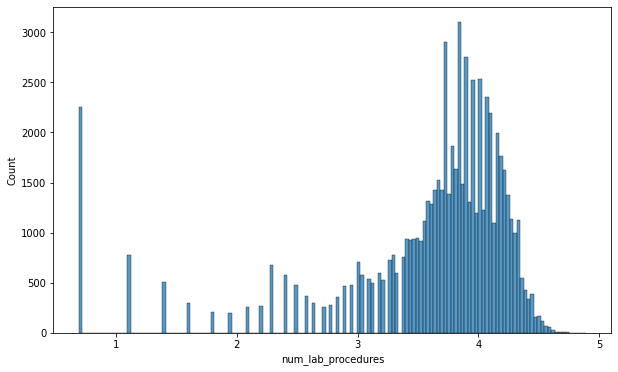

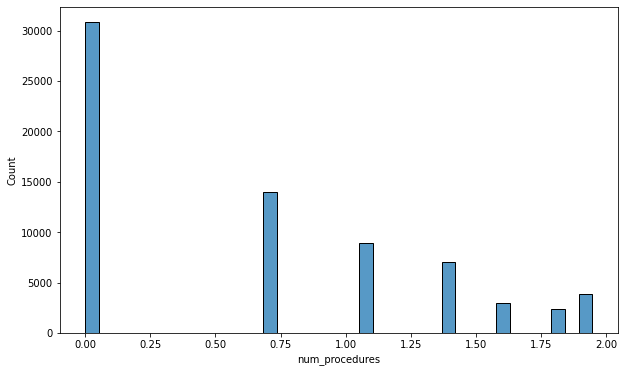

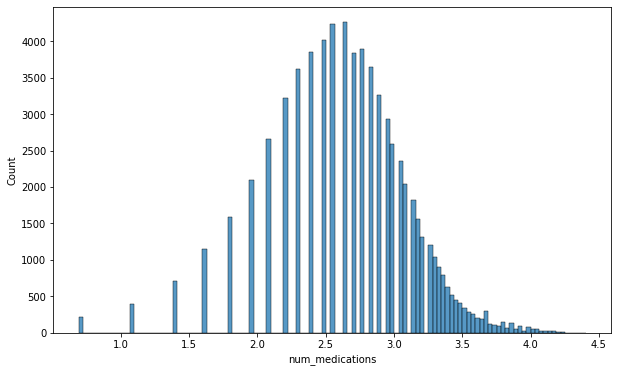

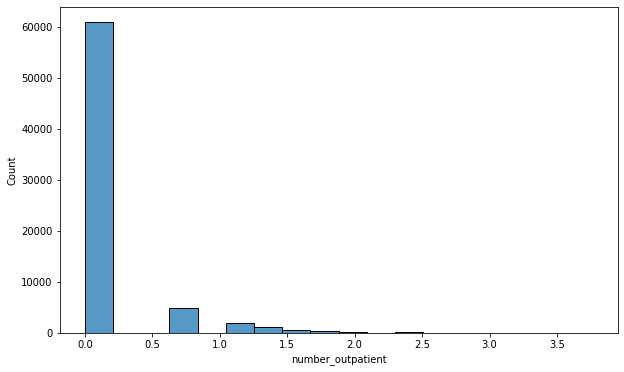

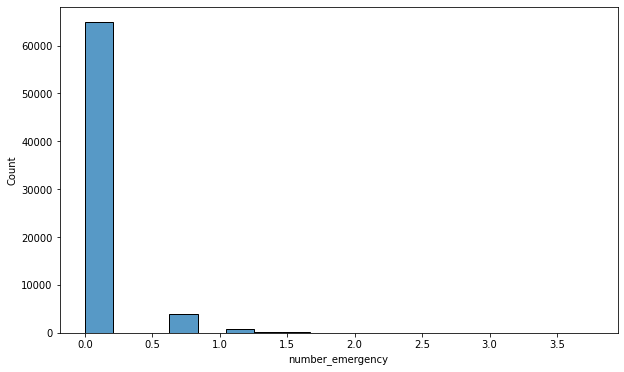

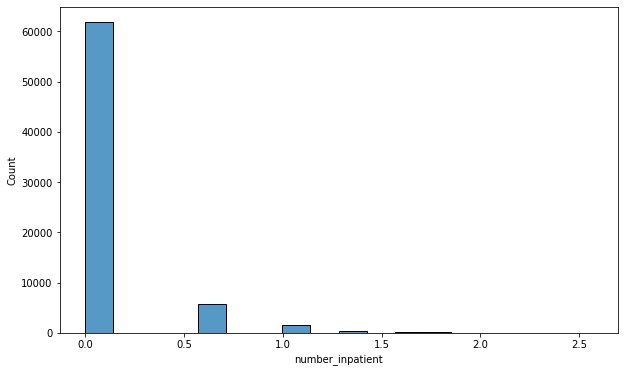

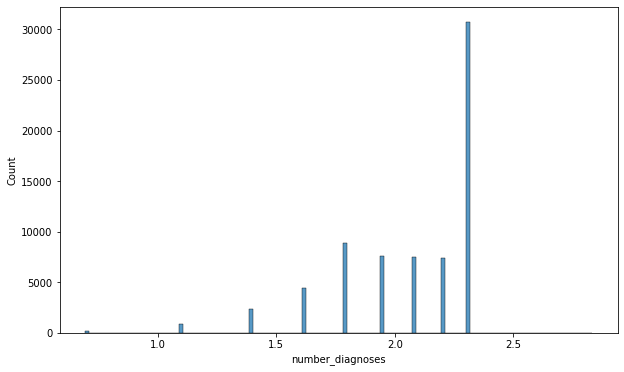

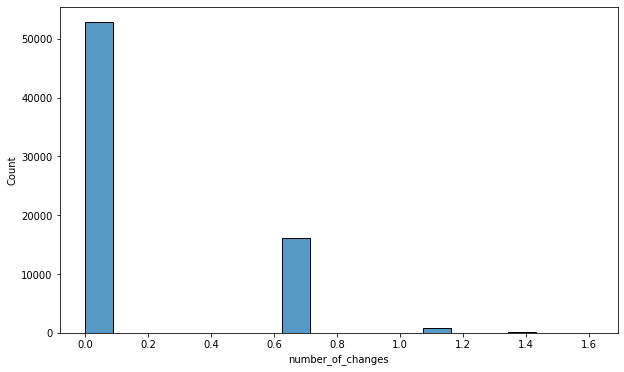

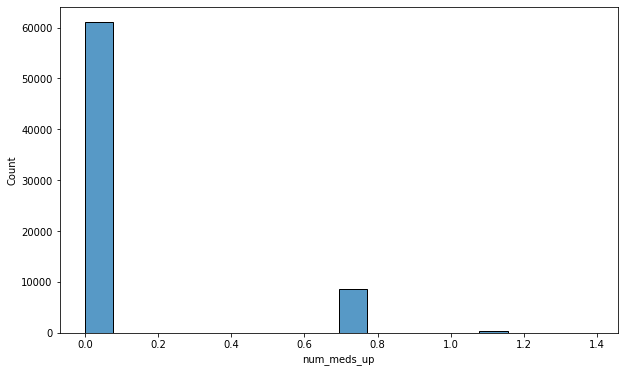

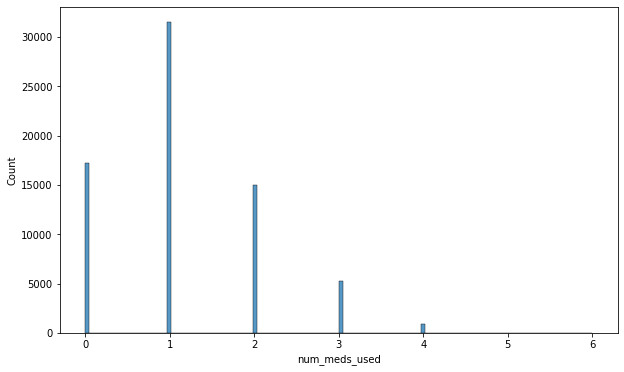

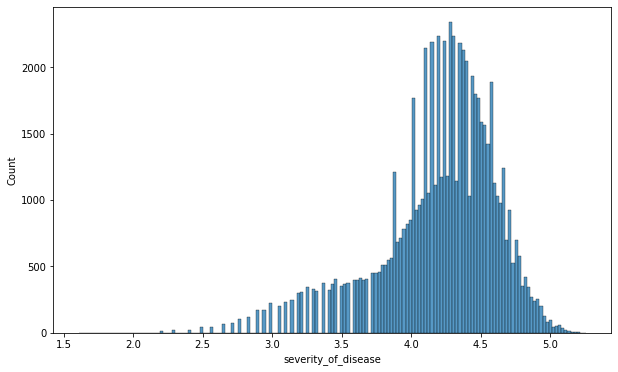

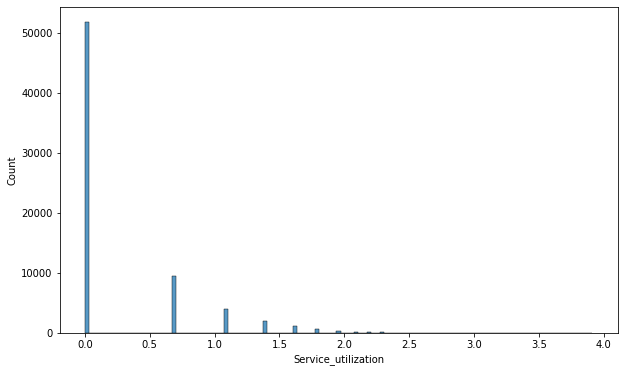

In [43]:
#Univariate analysis categoric variables
for i, feature in enumerate(numeric):
    col_values = diabetic_data[feature]
    fig = plt.figure(figsize=(10,6))
    sns.histplot(x=diabetic_data[feature])
    plt.show()

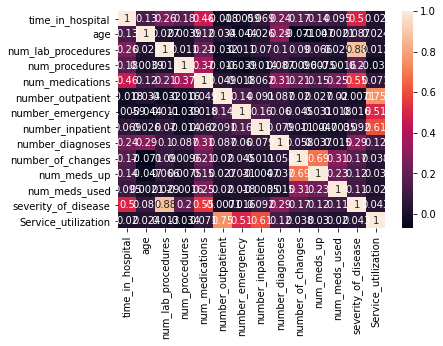

In [44]:
#Univariate analysis numeric variables
corrMatrix = diabetic_data[numeric].corr()
sns.heatmap(corrMatrix, annot=True)

In [45]:
for col in numeric:
  diabetic_data[col]=(diabetic_data[col] -np.mean(diabetic_data[col]))/np.sqrt(np.var(diabetic_data[col]))

In [47]:
for col in numeric:
    diabetic_data[col] = np.where(diabetic_data[col] >= diabetic_data[col].quantile(0.98),round(diabetic_data[col].quantile(0.98),2),diabetic_data[col])

## 5. Models

Removing Least Significant Categorical Features using Chi-Squared Test

In [48]:
#If p value is more than 0.4 the feature is removed
rejected_features=[]
for col in categorical: 
    data_crosstab = pd.crosstab(diabetic_data['readmitted'],  
                                diabetic_data[col], 
                                margins = False) 

    stat, p, dof, expected = scipy.stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

0.031112530606357942 race is significant
0.7366348140607145 gender is not significant
0.014866443237907109 admission_type_id is significant
3.338537767782864e-185 discharge_disposition_id is significant
0.12706323113631346 admission_source_id is significant
2.295099324671217e-15 diag_1 is significant
2.9489956725036214e-09 diag_2 is significant
1.3343805333195757e-08 diag_3 is significant
0.07208237144251049 max_glu_serum is significant
0.033049390952005764 A1Cresult is significant
0.031112530606357942 payer_code is significant
0.0013204595780973581 metformin is significant
0.6727124386862138 glimepiride is not significant
0.006796468752340401 glipizide is significant
0.1914068997152709 glyburide is significant
1.1130464548440412e-06 medical_specialty is significant
0.0 readmitted is significant
0.5266248028260246 pioglitazone is not significant
0.6860143186652338 rosiglitazone is not significant
4.4819939041352127e-10 insulin is significant
0.8656134241046397 glipizide-metformin is no

6 variables are not significant based on the Chi-Squared Test and are removed

In [49]:
#Drop no relevant features
diabetic_data=diabetic_data.drop(rejected_features,axis=1)

Removing Least Significant Numerical Features using Spearman Correlation Coefficient

In [50]:
#If p value is more than 0.4 the feature is removed
rejected_features_num=[]
for col in numeric:
    rho , pval = scipy.stats.spearmanr(diabetic_data['readmitted'], diabetic_data[col])
    if pval < 0.4 : 
        print(pval,col, 'is significant')
    else : 
        print(pval,col, 'is not significant')
        rejected_features_num.append(col)

1.342213921430941e-56 time_in_hospital is significant
2.1706878001154736e-37 age is significant
8.295316477788989e-18 num_lab_procedures is significant
0.35273143532792506 num_procedures is significant
1.371317842757273e-29 num_medications is significant
2.1350379955962818e-05 number_outpatient is significant
2.467701422519172e-15 number_emergency is significant
3.907118030924372e-111 number_inpatient is significant
6.726375303930287e-30 number_diagnoses is significant
9.622286476829324e-10 number_of_changes is significant
0.00669709575322697 num_meds_up is significant
9.795189313957816e-05 num_meds_used is significant
5.43120181382581e-38 severity_of_disease is significant
7.627548257202434e-67 Service_utilization is significant


In [51]:
#Drop no relevant features
diabetic_data=diabetic_data.drop(rejected_features_num,axis=1)

In [60]:
def metricas(y_true, y_pred):
    
    '''This function allows to measure some model metrics'''
    
    print('accuracy_score: ' + str(metrics.accuracy_score(y_true, y_pred)))
    print('precision_score: ' + str(metrics.precision_score(y_true, y_pred)))
    print('recall_score: ' + str(metrics.recall_score(y_true, y_pred)))
    print('f1_score: ' + str(metrics.f1_score(y_true, y_pred)))
    print('roc_auc_score: ' + str(metrics.roc_auc_score(y_true, y_pred)))

In [53]:
#We split the data in X and y
X_prev=diabetic_data.drop(['readmitted'],axis=1)
y=diabetic_data["readmitted"]

#Categorical features are encoded 
features_to_encode = list(diabetic_data.select_dtypes(include = ['object']).columns)
X = pd.get_dummies(X_prev, columns=features_to_encode)
columnas_X=X.columns

#Define pipeline
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.45)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X, y = pipeline.fit_resample(X, y)
X=pd.DataFrame(X,columns=columnas_X)

#Split the data in train and test
X_train, X_test, y_train, y_test =   train_test_split(X, y, test_size=0.3, random_state=21, stratify=y) 


Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


**Random Forest**

In [54]:
#Initiate the model
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=1234,
                      max_features='auto')

In [55]:
#Fit the model
rf_classifier=rf_classifier.fit(X_train,y_train)
#Predict with test data
predictions=rf_classifier.predict(X_test)
#Confusion matrix
metrics.confusion_matrix(y_test,predictions)

array([[16984,     1],
       [ 2726,  4918]])

In [61]:
metricas(y_test,predictions)

accuracy_score: 0.8892768687319826
precision_score: 0.9997967066476926
recall_score: 0.6433804290947148
f1_score: 0.7829340125766139
roc_auc_score: 0.8216607768081758


In [62]:
train_pred=rf_classifier.predict(X_train)
metrics.confusion_matrix(y_train,train_pred)

array([[39629,     3],
       [ 6074, 11760]])

In [63]:
metricas(y_train,train_pred)

accuracy_score: 0.8942505133470225
precision_score: 0.9997449630196379
recall_score: 0.659414601323315
f1_score: 0.7946751359935129
roc_auc_score: 0.8296694524581856


Results in train and test are similar so there aren't evidence of overfitting

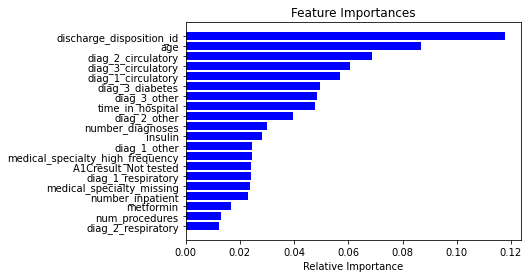

In [64]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[-20:]
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

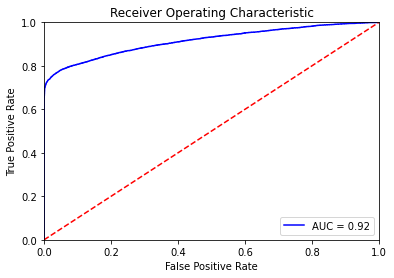

In [65]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [66]:
rf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)

In [67]:
metricas(y_test, y_test_pred)

accuracy_score: 0.9139226115554834
precision_score: 0.9916340334638661
recall_score: 0.728806907378336
f1_score: 0.8401447745438094
roc_auc_score: 0.8630198799476314


In [68]:
metrics.confusion_matrix(y_test,y_test_pred)

array([[16938,    47],
       [ 2073,  5571]])

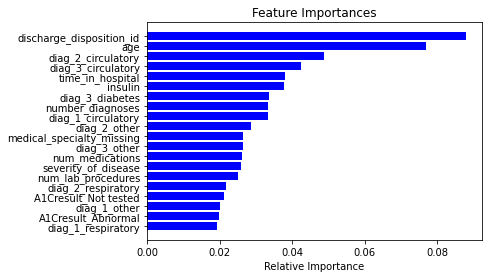

In [69]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

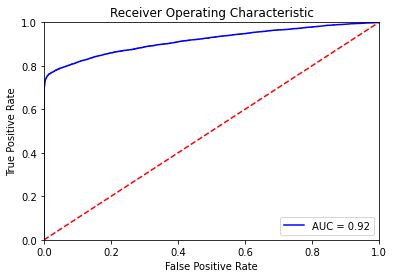

In [70]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()